In [2]:
import yaml
import os
import json
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit import qpy

# AUTHOR OF YAML PEIYI LI (pli11@ncsu.edu)
yamlfile = 'config.yaml'
with open(yamlfile, 'r') as file:
    config = yaml.safe_load(file)

shots = config['shots']
test_qubits = config['test_qubits']
parameters = config['parameters']
num_reps = config['reps']
enable_dd = config.get('enable_dd', False)
dd_sequence = ["X", "Y", "X", "Y"]
obs_list = config['obs_list_layer_0']
prep_state_list = config['prep_state_list_layer_0']

In [3]:
# Dynamical Decoupling insertion function
def insert_dd_sequence(qc, dd_sequence=["X", "Y", "X", "Y"]):
    for gate in dd_sequence:
        for qubit in range(qc.num_qubits):
            if gate.upper() == "X":
                qc.x(qubit)
            elif gate.upper() == "Y":
                qc.y(qubit)
            elif gate.upper() == "Z":
                qc.z(qubit)
    return qc

# Hellinger fidelity calculation
def hellinger_fidelity(dist_p, dist_q):
    p_sum = sum(dist_p.values())
    q_sum = sum(dist_q.values())
    keys = set(dist_p.keys()) | set(dist_q.keys())
    total = sum((np.sqrt(dist_p.get(k, 0)/p_sum) - np.sqrt(dist_q.get(k, 0)/q_sum))**2 for k in keys)
    return 1 - np.sqrt(total)/np.sqrt(2)
    

In [4]:
## VQE circuit from quTracer with added dd flag 

In [5]:
def generate_circuit(test_qubits, parameters, num_reps, enable_dd=False, dd_sequence=None):
    qc = QuantumCircuit(test_qubits)
    
    for i in range(test_qubits):
        qc.ry(parameters[i], i)

    for j in range(num_reps):
        for i in range(test_qubits - 1):
            qc.cz(i, i + 1)
        
        if enable_dd and dd_sequence:
            for gate in dd_sequence:
                for q in range(test_qubits):
                    getattr(qc, gate.lower())(q)
        
        for i in range(test_qubits):
            qc.ry(parameters[(1 + j) * test_qubits + i], i)
            
    return qc


In [6]:
## JUST COPIED EVERY HELPER FROM QUTRACER ###

In [7]:
global_creg_counter = 0
# author: Peiyi Li (pli11@ncsu.edu)

def get_frag_num(wire_path_map):
    return len(set( frag_wire[0] for path in wire_path_map.values()
                    for frag_wire in path ))

# identify all stitches in a cut-up circuit, in dictionary format:
#   { <exit wire> : <init wire> }
def identify_stitches(wire_path_map):
    circuit_wires = list(wire_path_map.keys())
    stitches = {}
    for wire in circuit_wires:
        # identify all init/exit wires in the path of this wire
        init_wires = wire_path_map[wire][1:]
        exit_wires = wire_path_map[wire][:-1]
        # add the stitches in this path
        stitches.update({ exit_wire : init_wire
                          for init_wire, exit_wire in zip(init_wires, exit_wires) })
    return stitches

# identify preparation / meauserment qubits for all fragments
def identify_frag_targets(wire_path_map):
    stitches = identify_stitches(wire_path_map)
    frag_targets = [ { "meas" : tuple(), "prep" : tuple() }
                     for _ in range(get_frag_num(wire_path_map)) ]
    for meas_frag_qubit, prep_frag_qubit in stitches.items():
        meas_frag, meas_qubit = meas_frag_qubit
        prep_frag, prep_qubit = prep_frag_qubit
        frag_targets[meas_frag]["meas"] += (meas_qubit,)
        frag_targets[prep_frag]["prep"] += (prep_qubit,)
    return frag_targets


def obtain_prep_dict(wire_path_map):
    stitches=identify_stitches(wire_path_map)
    
    prep_dict={}
    for meas_frag_qubit, prep_frag_qubit in stitches.items():
        #meas_frag, meas_qubit = meas_frag_qubit
        prep_frag, prep_qubit = prep_frag_qubit
        if prep_frag not in prep_dict.keys():
            prep_dict[prep_frag]=(prep_qubit,)
        else:
            prep_dict[prep_frag]+=(prep_qubit,)
            
    return prep_dict

def obtain_meas_dict(wire_path_map):
    stitches=identify_stitches(wire_path_map)
    
    meas_dict={}
    for meas_frag_qubit, prep_frag_qubit in stitches.items():
        meas_frag, meas_qubit = meas_frag_qubit
        #prep_frag, prep_qubit = prep_frag_qubit
        if meas_frag not in meas_dict.keys():
            meas_dict[meas_frag]=(meas_qubit,)
        else:
            meas_dict[meas_frag]+=(meas_qubit,)
            
    return meas_dict
        
def obtain_prep_info(wire_path_map):
    prep_dict=obtain_prep_dict(wire_path_map)
    
    prep_fragment_index_list=[]
    prep_qubits_list=[]
    for prep_fragment_index,prep_qubits in prep_dict.items():
        prep_fragment_index_list.append(prep_fragment_index)
        prep_qubits_list.append(prep_qubits)
    #print(prep_fragment_index_list)
    #print(prep_qubits_list)
    return (prep_fragment_index_list,prep_qubits_list)

def obtain_meas_info(wire_path_map):
    meas_dict=obtain_meas_dict(wire_path_map)
    
    meas_fragment_index_list=[]
    meas_qubits_list=[]
    for meas_fragment_index,meas_qubits in meas_dict.items():
        meas_fragment_index_list.append(meas_fragment_index)
        meas_qubits_list.append(meas_qubits)
    #print(meas_fragment_index_list)
    #print(meas_qubits_list)
    return (meas_fragment_index_list,meas_qubits_list)

#########################################################################

def generate_circuit_adding_measurement(qc,measured_qubits,prep_qubits):
    global global_creg_counter
    new_qc=qc.copy()
    
    subcircuit=QuantumCircuit(1)
    subcircuit.barrier(0)
    
    for qbit in prep_qubits:
        new_qc=new_qc.compose(subcircuit,[qbit.index],front=True)
        
    c_reg_name = f'c_{global_creg_counter}'
    global_creg_counter += 1
    c_reg = ClassicalRegister(len(measured_qubits), c_reg_name)
    new_qc.add_register(c_reg)
    
    i=0
    for qbit in measured_qubits:
        new_qc.barrier(qbit.index)
        new_qc.measure(qbit.index,i)
        i+=1
    return new_qc    

#generate circuits after cutting
def generate_circuit_after_cutting(circuit, check_qubits, check_position):
    #specify the info of cut
    cuts = list(zip((circuit.qubits[qbit] for qbit in check_qubits), check_position))
    #do circuit cutting
    fragments, wire_path_map = cut_circuit(circuit, cuts)
    
    #obtain the info of prep circuits
    prep_fragment_index_list,prep_qubits_list=obtain_prep_info(wire_path_map)
    assert(len(prep_fragment_index_list)==1)
    assert(len(prep_qubits_list)==1)
    prep_fragment_index=prep_fragment_index_list[0]
    prep_qubits=prep_qubits_list[0]
    
    #obtain the info of meas circuits
    meas_fragment_index_list,meas_qubits_list=obtain_meas_info(wire_path_map)
    meas_fragment_index=meas_fragment_index_list[0]
    meas_qubits=meas_qubits_list[0]
    
    #obtain the prep circuit and add measurement
    qc=fragments[prep_fragment_index]
    #obtain the meas circuit(to do: may have multiple framgment of meas circuits)
    meas_qc=fragments[meas_fragment_index]
    #layer n (n>0)
    if (len(meas_fragment_index_list)==1) and (prep_fragment_index==meas_fragment_index):   
        prep_qc=generate_circuit_adding_measurement(qc,meas_qubits+prep_qubits,prep_qubits)
    #layer 0     
    else:
        prep_qc=generate_circuit_adding_measurement(qc,prep_qubits,prep_qubits)
    return prep_qc,meas_qc,prep_qubits,meas_qubits
###########################################################################
def obtain_initial_physical_qubits_index(qc, logical_qubits):
    layout = qc._layout
    
    initial_virtual_layout=layout.initial_virtual_layout(filter_ancillas=False)
    initial_index_layout=layout.initial_index_layout(filter_ancillas=False)
    
    record_qubits_index=[]
    
    for logical_qubit in logical_qubits:
        for physical_qubit in initial_index_layout:
            if initial_virtual_layout[physical_qubit]==logical_qubit:
                record_qubits_index.append(physical_qubit)
                break
    return record_qubits_index

def obtain_final_physical_qubits_index_for_measurement(qc):
    record_qubits_index=[]
    for quantum_register in qc.data:
        if(quantum_register[0].name == 'measure'):
            #print(quantum_register[1][0])
            qubit_index = qc.find_bit(quantum_register[1][0]).index
            record_qubits_index.append(qubit_index)
    return record_qubits_index
############################################################################
def get_gate_information(circuit):
    gate_info = []
    for instruction in circuit.data:
        gate = instruction[0]
        qubits = instruction[1]
        params = gate.params
        gate_info.append({
            "name": gate.name,
            "qubits": [qubit.index for qubit in qubits],
            "params": params
        })
    return gate_info
###############################################################################
def create_circuit_for_term1(qc,subcircuit,new_prep_qubit_index_transpiled_measurement,new_prep_qubit_index_transpiled,obs='I'):
    global global_creg_counter
    new_qc=qc.copy()
    if (subcircuit):
        new_qc=qc.compose(subcircuit,new_prep_qubit_index_transpiled,front=True)
    
    # Create a Classical Register with 1 bits.
    c_reg_name = f'c_{global_creg_counter}'
    global_creg_counter += 1
    c_reg = ClassicalRegister(1, c_reg_name)
    new_qc.add_register(c_reg)
    if(obs=='X'):
        new_qc.h(new_prep_qubit_index_transpiled_measurement[0])
    elif(obs=='Y'):
        new_qc.sdg(new_prep_qubit_index_transpiled_measurement[0])  
        new_qc.h(new_prep_qubit_index_transpiled_measurement[0])  
    new_qc.measure(new_prep_qubit_index_transpiled_measurement[0],0)
    
    return new_qc

def create_circuit_for_term4(qc,subcircuit,new_prep_qubit_index_transpiled_measurement,new_prep_qubit_index_transpiled,obs='I'):
    global global_creg_counter
    subcircuit0=QuantumCircuit(1)
    subcircuit0.z(0)
    new_qc0=qc.compose(subcircuit0,new_prep_qubit_index_transpiled,front=True)
    new_qc1=new_qc0.compose(subcircuit,new_prep_qubit_index_transpiled,front=True)
    
    c_reg_name = f'c_{global_creg_counter}'
    global_creg_counter += 1
    c_reg = ClassicalRegister(1, c_reg_name)
    new_qc1.add_register(c_reg)
    
    new_qc1.z(new_prep_qubit_index_transpiled_measurement[0])

    if(obs=='X'):
        new_qc1.h(new_prep_qubit_index_transpiled_measurement[0])
    elif(obs=='Y'):
        new_qc1.sdg(new_prep_qubit_index_transpiled_measurement[0])  
        new_qc1.h(new_prep_qubit_index_transpiled_measurement[0])  
    new_qc1.measure(new_prep_qubit_index_transpiled_measurement[0],0)
    
    return new_qc1

def create_circuits_with_certain_prep_meas_cutting_1q_layer_0(qc,new_prep_qubit_index_transpiled_measurement,new_prep_qubit_index_transpiled,prep_state,obs='I'):
    global global_creg_counter
    subcircuit=QuantumCircuit(1)
    #prep_state
    if(prep_state=='Z_n'):
        subcircuit.x(0)
    elif(prep_state=='X_p'):
        subcircuit.h(0)
    elif(prep_state=='X_n'):
        subcircuit.x(0)
        subcircuit.h(0)
    elif(prep_state=='Y_p'):
        subcircuit.h(0)
        subcircuit.s(0)
    elif(prep_state=='Y_n'):
        subcircuit.h(0)
        subcircuit.sdg(0)
        
    new_qc=qc.compose(subcircuit,new_prep_qubit_index_transpiled,front=True)
    
    # Create a Classical Register with 1 bits.
    c_reg_name = f'c_{global_creg_counter}'
    global_creg_counter += 1
    c_reg = ClassicalRegister(1, c_reg_name)
    new_qc.add_register(c_reg)
    qubits_final_index=new_prep_qubit_index_transpiled_measurement[0]
    if(obs=='X'):
        new_qc.h(qubits_final_index)
    elif(obs=='Y'):
        new_qc.sdg(qubits_final_index)  
        new_qc.h(qubits_final_index)  
    new_qc.measure(qubits_final_index,0)
    
    return new_qc

def create_circuits_with_certain_prep_meas_cutting_1q_layer_n(qc,new_prep_qubit_index_transpiled_measurement,new_prep_qubit_index_transpiled,prep_state,obs_meas='I',obs_final='I'):
    global global_creg_counter
    subcircuit=QuantumCircuit(1)
    #prep_state
    if(prep_state=='Z_n'):
        subcircuit.x(0)
    elif(prep_state=='X_p'):
        subcircuit.h(0)
    elif(prep_state=='X_n'):
        subcircuit.x(0)
        subcircuit.h(0)
    elif(prep_state=='Y_p'):
        subcircuit.h(0)
        subcircuit.s(0)
    elif(prep_state=='Y_n'):
        subcircuit.h(0)
        subcircuit.sdg(0)
        
    new_qc=qc.compose(subcircuit,new_prep_qubit_index_transpiled,front=True)
    
    # Create a Classical Register with 2 bits.
    c_reg_name = f'c_{global_creg_counter}'
    global_creg_counter += 1
    c_reg = ClassicalRegister(2, c_reg_name)
    new_qc.add_register(c_reg)
    if(obs_meas=='X'):
        new_qc.h(new_prep_qubit_index_transpiled_measurement[0])
    elif(obs_meas=='Y'):
        new_qc.sdg(new_prep_qubit_index_transpiled_measurement[0])  
        new_qc.h(new_prep_qubit_index_transpiled_measurement[0])
    
    if(obs_final=='X'):
        new_qc.h(new_prep_qubit_index_transpiled_measurement[1])
    elif(obs_final=='Y'):
        new_qc.sdg(new_prep_qubit_index_transpiled_measurement[1])  
        new_qc.h(new_prep_qubit_index_transpiled_measurement[1])
    
    new_qc.measure(new_prep_qubit_index_transpiled_measurement[0],0)
    new_qc.measure(new_prep_qubit_index_transpiled_measurement[1],1)
    
    return new_qc

def create_circuits_with_certain_prep_meas_cutting_2q_layer_0(qc,new_prep_qubit_index_transpiled_measurement,new_prep_qubit_index_transpiled,prep_state,obs='II'):
    global global_creg_counter
    subcircuit=QuantumCircuit(1)
    #prep_state[0]
    if(prep_state[-1]=='Z_n'):
        subcircuit.x(0)
    elif(prep_state[-1]=='X_p'):
        subcircuit.h(0)
    elif(prep_state[-1]=='X_n'):
        subcircuit.x(0)
        subcircuit.h(0)
    elif(prep_state[-1]=='Y_p'):
        subcircuit.h(0)
        subcircuit.s(0)
    elif(prep_state[-1]=='Y_n'):
        subcircuit.h(0)
        subcircuit.sdg(0)
    new_qc=qc.compose(subcircuit,[new_prep_qubit_index_transpiled[0]],front=True)
    
    subcircuit=QuantumCircuit(1)
    #prep_state[1]
    if(prep_state[-2]=='Z_n'):
        subcircuit.x(0)
    elif(prep_state[-2]=='X_p'):
        subcircuit.h(0)
    elif(prep_state[-2]=='X_n'):
        subcircuit.x(0)
        subcircuit.h(0)
    elif(prep_state[-2]=='Y_p'):
        subcircuit.h(0)
        subcircuit.s(0)
    elif(prep_state[-2]=='Y_n'):
        subcircuit.h(0)
        subcircuit.sdg(0)
    new_qc=new_qc.compose(subcircuit,[new_prep_qubit_index_transpiled[1]],front=True)
           
    
    # Create a Classical Register with 1 bits.
    c_reg_name = f'c_{global_creg_counter}'
    global_creg_counter += 1
    c_reg = ClassicalRegister(2, c_reg_name)
    new_qc.add_register(c_reg)
    if(obs[-1]=='X'):
        new_qc.h(new_prep_qubit_index_transpiled_measurement[0])
    elif(obs[-1]=='Y'):
        new_qc.sdg(new_prep_qubit_index_transpiled_measurement[0])  
        new_qc.h(new_prep_qubit_index_transpiled_measurement[0])
    if(obs[-2]=='X'):
        new_qc.h(new_prep_qubit_index_transpiled_measurement[1])
    elif(obs[-2]=='Y'):
        new_qc.sdg(new_prep_qubit_index_transpiled_measurement[1])  
        new_qc.h(new_prep_qubit_index_transpiled_measurement[1])
    new_qc.measure(new_prep_qubit_index_transpiled_measurement[0],0)
    new_qc.measure(new_prep_qubit_index_transpiled_measurement[1],1)
    
    return new_qc

def create_circuits_with_certain_prep_meas_cutting_2q_layer_n(qc,new_prep_qubit_index_transpiled_measurement,new_prep_qubit_index_transpiled,prep_state,obs_meas='II',obs_final='II'):
    global global_creg_counter
    subcircuit=QuantumCircuit(1)
    #prep_state[0]
    if(prep_state[-1]=='Z_n'):
        subcircuit.x(0)
    elif(prep_state[-1]=='X_p'):
        subcircuit.h(0)
    elif(prep_state[-1]=='X_n'):
        subcircuit.x(0)
        subcircuit.h(0)
    elif(prep_state[-1]=='Y_p'):
        subcircuit.h(0)
        subcircuit.s(0)
    elif(prep_state[-1]=='Y_n'):
        subcircuit.h(0)
        subcircuit.sdg(0)
    new_qc=qc.compose(subcircuit,[new_prep_qubit_index_transpiled[0]],front=True)
    
    subcircuit=QuantumCircuit(1)
    #prep_state[1]
    if(prep_state[-2]=='Z_n'):
        subcircuit.x(0)
    elif(prep_state[-2]=='X_p'):
        subcircuit.h(0)
    elif(prep_state[-2]=='X_n'):
        subcircuit.x(0)
        subcircuit.h(0)
    elif(prep_state[-2]=='Y_p'):
        subcircuit.h(0)
        subcircuit.s(0)
    elif(prep_state[-2]=='Y_n'):
        subcircuit.h(0)
        subcircuit.sdg(0)
    new_qc=new_qc.compose(subcircuit,[new_prep_qubit_index_transpiled[1]],front=True)
           
    
    # Create a Classical Register with 1 bits.
    c_reg_name = f'c_{global_creg_counter}'
    global_creg_counter += 1
    c_reg = ClassicalRegister(4, c_reg_name)
    new_qc.add_register(c_reg)
    if(obs_meas[-1]=='X'):
        new_qc.h(new_prep_qubit_index_transpiled_measurement[0])
    elif(obs_meas[-1]=='Y'):
        new_qc.sdg(new_prep_qubit_index_transpiled_measurement[0])  
        new_qc.h(new_prep_qubit_index_transpiled_measurement[0])
    if(obs_meas[-2]=='X'):
        new_qc.h(new_prep_qubit_index_transpiled_measurement[1])
    elif(obs_meas[-2]=='Y'):
        new_qc.sdg(new_prep_qubit_index_transpiled_measurement[1])  
        new_qc.h(new_prep_qubit_index_transpiled_measurement[1])
    new_qc.measure(new_prep_qubit_index_transpiled_measurement[0],0)
    new_qc.measure(new_prep_qubit_index_transpiled_measurement[1],1)
    
    if(obs_final[-1]=='X'):
        new_qc.h(new_prep_qubit_index_transpiled_measurement[2])
    elif(obs_final[-1]=='Y'):
        new_qc.sdg(new_prep_qubit_index_transpiled_measurement[2])  
        new_qc.h(new_prep_qubit_index_transpiled_measurement[2])
    if(obs_final[-2]=='X'):
        new_qc.h(new_prep_qubit_index_transpiled_measurement[3])
    elif(obs_final[-2]=='Y'):
        new_qc.sdg(new_prep_qubit_index_transpiled_measurement[3])  
        new_qc.h(new_prep_qubit_index_transpiled_measurement[3])
    new_qc.measure(new_prep_qubit_index_transpiled_measurement[2],2)
    new_qc.measure(new_prep_qubit_index_transpiled_measurement[3],3)
    
    return new_qc
#####################################################################################
X_eigen_states = ['X_p', 'X_n']
Y_eigen_states = ['Y_p', 'Y_n']
Z_eigen_states = ['Z_p', 'Z_n']
I_eigen_states = ['Z_p', 'Z_n']

dict_for_create_circuit_term_1_4={'X':[X_eigen_states], 'Y':[Y_eigen_states]}
dict_for_create_circuit_term_2_3={'X':[Y_eigen_states], 'Y':[X_eigen_states]}
dict_for_create_circuit_term_common={'Z':[Z_eigen_states]}

dict_for_create_circuit={'XX':[(X_eigen_states,X_eigen_states),(Y_eigen_states,Y_eigen_states),(X_eigen_states,Y_eigen_states),(Y_eigen_states,X_eigen_states)],
                         'XY':[(X_eigen_states,X_eigen_states),(Y_eigen_states,Y_eigen_states),(X_eigen_states,Y_eigen_states),(Y_eigen_states,X_eigen_states)],
                         'YX':[(X_eigen_states,X_eigen_states),(Y_eigen_states,Y_eigen_states),(X_eigen_states,Y_eigen_states),(Y_eigen_states,X_eigen_states)],
                         'YY':[(X_eigen_states,X_eigen_states),(Y_eigen_states,Y_eigen_states),(X_eigen_states,Y_eigen_states),(Y_eigen_states,X_eigen_states)],
                         'XZ':[(X_eigen_states,Z_eigen_states),(Y_eigen_states,Z_eigen_states)],
                         'YZ':[(X_eigen_states,Z_eigen_states),(Y_eigen_states,Z_eigen_states)],
                         'ZX':[(Z_eigen_states,X_eigen_states),(Z_eigen_states,Y_eigen_states)],
                         'ZY':[(Z_eigen_states,X_eigen_states),(Z_eigen_states,Y_eigen_states)],
                         'ZZ':[(Z_eigen_states,Z_eigen_states)],
                        }
obs_dict = {'X':'Y', 'Y':'X', 'Z':'I', 'I':'Z'}

from qiskit import  transpile
def generate_execution_circuits_list(prep_qc, meas_qc, backend, qubits_initial_index_list, qubits_final_index_list, obs_list, prep_state_list):
    qc_list=[]
    
    #generate circuits for layer 0 and layer n (n>0)
    #circuits for layer 0 
    if len(prep_state_list) == 4:
        #cutting 1 qubit
        if len(qubits_initial_index_list)==1:
            #when obs_list just has one observable, decide if can do further optimizaiton
            if len(obs_list)==1:
                obs = obs_list[0]
                #can do further optimization (to do: need to fill in the case when can not do further optimization)
                if meas_qc.num_qubits == 1:
                    #circuit for term1
                    circ = create_circuit_for_term1(prep_qc,meas_qc,qubits_final_index_list,qubits_initial_index_list,obs=obs) 
                    qc_list.append(circ)
                    #circuit for term4
                    circ = create_circuit_for_term4(prep_qc,meas_qc,qubits_final_index_list,qubits_initial_index_list,obs=obs) 
                    qc_list.append(circ)
                    #circuit for term2 and term3
                    for prep_state in prep_state_list:
                        circ = create_circuits_with_certain_prep_meas_cutting_1q_layer_0(prep_qc,qubits_final_index_list,qubits_initial_index_list,prep_state,obs_dict[obs])
                        qc_list.append(circ)
                    #circuit for term2 and term3 (denominator)
                    for prep_state in prep_state_list:
                        circ = create_circuits_with_certain_prep_meas_cutting_1q_layer_0(prep_qc,qubits_final_index_list,qubits_initial_index_list,prep_state,obs_dict['I'])
                        qc_list.append(circ)
        #cutting more than 1 qubit
        else:
            for obs in obs_list:
                for prep_state_1 in prep_state_list:
                    for prep_state_0 in prep_state_list:
                        prep_state=[prep_state_1,prep_state_0]
                        circ = create_circuits_with_certain_prep_meas_cutting_2q_layer_0(prep_qc,qubits_final_index_list,qubits_initial_index_list,prep_state,obs)
                        qc_list.append(circ)
    
    #circuits for layer n
    else:
        if len(qubits_initial_index_list)==1:
            #create circuits for term 1 and 4
            for obs_final in obs_list:
                for obs_meas,prep_state_list in dict_for_create_circuit_term_1_4.items():
                    for prep_state in prep_state_list[0]:
                        circ = create_circuits_with_certain_prep_meas_cutting_1q_layer_n(prep_qc,qubits_final_index_list,qubits_initial_index_list,prep_state,obs_meas,obs_final)
                        qc_list.append(circ)
            #create circuits for term 2 and 3
            #to do: need to process the case when all three obs are measured
            for obs_final in obs_list + ['I']:
                for obs_meas,prep_state_list in dict_for_create_circuit_term_2_3.items():
                    for prep_state in prep_state_list[0]:
                        circ = create_circuits_with_certain_prep_meas_cutting_1q_layer_n(prep_qc,qubits_final_index_list,qubits_initial_index_list,prep_state,obs_meas,obs_dict[obs_final])
                        qc_list.append(circ)
            #create circuits for common part
            for obs_final in ['X','Y','Z']:
                for obs_meas,prep_state_list in dict_for_create_circuit_term_common.items():
                    for prep_state in prep_state_list[0]:
                        circ = create_circuits_with_certain_prep_meas_cutting_1q_layer_n(prep_qc,qubits_final_index_list,qubits_initial_index_list,prep_state,obs_meas,obs_final)
                        qc_list.append(circ)
        else:
            for obs_final in obs_list:
                for obs_meas,prep_state_list in dict_for_create_circuit.items():
                    for (prep_state_1_list,prep_state_0_list) in prep_state_list:
                        for prep_state_1 in prep_state_1_list:
                            for prep_state_0 in prep_state_0_list:
                                prep_state=[prep_state_1,prep_state_0]
                                circ = create_circuits_with_certain_prep_meas_cutting_2q_layer_n(prep_qc,qubits_final_index_list,qubits_initial_index_list,prep_state,obs_meas,obs_final)
                                qc_list.append(circ)
                            
    new_qc_list = transpile(qc_list, backend, layout_method='trivial',optimization_level=3)
    #print(len(new_qc_list))
    return new_qc_list



In [8]:
#!/usr/bin/env python3

# author: Michael A. Perlin (github.com/perlinm), modified by Ji Liu (ji.liu@anl.gov), 
#modified by Peiyi Li(pli11@ncsu.edu) to make it aligh with Qiskit 0.45.1

import retworkx as rx
import qiskit as qs
import copy
from qiskit.dagcircuit.dagnode import DAGOpNode, DAGInNode, DAGOutNode
from qiskit.dagcircuit import DAGCircuit
import collections
from retworkx.visualization import mpl_draw


##########################################################################################
# this script cuts a quantum circuit built in qiskit
# cutting is performed using method described in arxiv.org/abs/2005.12702
##########################################################################################

# get the terminal node of a qubit in a graph
def terminal_node(graph, qubit, termination_type):
    assert( termination_type in [ "in", "out" ] )
    if termination_type=="in":
        node_type=DAGInNode
    else:
        node_type=DAGOutNode
    for node in graph._multi_graph.nodes():
        if type(node) == node_type and node.wire == qubit:
            return node
        
# accept a circuit graph (in DAG form), and return a list of connected subgraphs       
def disjoint_subgraphs(graph):
    #graph = circuit_to_dag(circuit)

    rx_graph = graph._multi_graph

    # identify all subgraphs of nodes
    rx_subgraphs = [rx_graph.subgraph(list(subgraph_nodes))
                    for subgraph_nodes in rx.weakly_connected_components(rx_graph)]

    # convert subgraphs of nodes to circuit graphs
    subgraphs = []
    for rx_subgraph in rx_subgraphs:
        # make a copy of the full graph, and remove nodes not in this subgraph
        subgraph = copy.deepcopy(graph)
        rx_subgraph_opnodes = [rx_node for rx_node in rx_subgraph.nodes() if isinstance(rx_node, DAGOpNode)]

        # Create bit index mapping for semantic_eq
        bit_indices = {bit: idx for idx, bit in enumerate(subgraph.qubits + subgraph.clbits)}

        keep_nodes = [node for node in subgraph.op_nodes() for rx_node in rx_subgraph_opnodes 
                      if DAGOpNode.semantic_eq(node, rx_node, bit_indices, bit_indices)]

        remove_nodes = [node for node in subgraph.op_nodes() if node not in keep_nodes]
        for node in remove_nodes:
            subgraph.remove_op_node(node)

        # ignore trivial subgraphs
        if len(subgraph.op_nodes()) == 0: 
            continue
        subgraphs.append(subgraph)

    return subgraphs

# "trim" a circuit graph (in DAG form) by eliminating unused bits
# return trimmed graph, and a dictionary mapping old wires to new ones
def trimmed_graph(graph, qreg_name = "q", creg_name = "c"):
    # idenify wires used in this graph
    wires = set.union(*[ set(node.qargs) for node in graph.op_nodes() ])

    # construct map from old bits to new ones
    old_qbits = [ wire for wire in wires
                  if type(wire.register) is qs.circuit.quantumregister.QuantumRegister
                  or type(wire.register) is qs.circuit.quantumregister.AncillaRegister ]
    old_cbits = [ wire for wire in wires
                  if type(wire.register) is qs.circuit.classicalregister.ClassicalRegister ]

    new_qbits = qs.QuantumRegister(len(old_qbits), qreg_name) if len(old_qbits) > 0 else []
    new_cbits = qs.ClassicalRegister(len(old_cbits), creg_name) if len(old_cbits) > 0 else []

    registers = [ reg for reg in [ new_qbits, new_cbits ] if reg != [] ]
    trimmed_circuit = qs.QuantumCircuit(*registers)

    register_map = list(zip(old_qbits, new_qbits)) + list(zip(old_cbits, new_cbits))
    register_map = { old_bit : new_bit for old_bit, new_bit in register_map }

    # add all operations to the trimmed circuit
    for node in graph.topological_op_nodes():
        new_qargs = [ register_map[qbit] for qbit in node.qargs ]
        new_cargs = [ register_map[cbit] for cbit in node.cargs ]
        trimmed_circuit.append(node.op, qargs = new_qargs, cargs = new_cargs)

    return qs.converters.circuit_to_dag(trimmed_circuit), register_map

# accepts a circuit and list of cuts in the format (wire, op_number),
#   where op_number is the number of operations performed on the wire before the cut
# returns:
# (i) a list of subcircuits (as qiskit QuantumCircuit objects)
# (ii) a "path map", or a dictionary mapping a wire in the original circuit to
#        a list of wires in subcircuits traversed by the original wire:
#      { < wire in original circuit > :
#        [ ( < index of subcircuit  >, < wire in subcircuit > ) ] }
def cut_circuit(circuit, cuts, qreg_name = "q", creg_name = "c"):
    # assert that all cut wires are part of a quantum register
    assert(all( type(wire) is qs.circuit.quantumregister.Qubit for wire, _ in cuts ))

    # construct graph for this circuit
    graph = qs.converters.circuit_to_dag(circuit.copy())

    # all wires in the original circuit
    circuit_wires = circuit.qubits + circuit.clbits

    # initialize new qubit register and construct total circuit graph
    if len(cuts) > 0:
        old_reg_names = set( wire.register.prefix for wire in circuit_wires )
        new_reg_name = "_".join(old_reg_names) + "_new"
        new_register = qs.QuantumRegister(len(cuts),new_reg_name)
        new_wires = iter(new_register)
        graph.add_qreg(new_register)
    node_idx = { node : idx for node, idx in zip(graph._multi_graph.nodes(),
                                                 graph._multi_graph.node_indexes()) }
    def _add_edge(node1, node2, **kwargs):
        graph._multi_graph.add_edge(node_idx[node1], node_idx[node2], kwargs)
    def _remove_edge(node1, node2, data = None):
        #print("enter function")
        idx1, idx2 = node_idx[node1], node_idx[node2]
        # todo: remove "not data"
        if data is None or len(graph._multi_graph.get_all_edge_data(idx1, idx2)) == 1:
            # there is only one edge between the given nodes
            #print("enter function if")
            graph._multi_graph.remove_edge(idx1, idx2)
        '''    
        else:
            # there are multiple edges between the given nodes
            # determine the index of the given edge and remove it by index
            print("enter function else")
            edge_iterator = zip(graph._multi_graph.edge_list(),
                                graph._multi_graph.edges())
            for edge_idx, ( ( _idx1, _idx2 ), _data ) in enumerate(edge_iterator):
                if _idx1 != idx1 or _idx2 != idx2: continue
                if all( _data[key] == data[key] for key in data.keys() ):
                    graph._multi_graph.remove_edge_from_index(edge_idx)
                    break
        '''
    # TODO: deal with barriers properly
    # barriers currently interfere with splitting a graph into subgraphs
    graph.remove_all_ops_named("barrier")

    # tuples identifying which old/new wires to stitch together
    stitches = {}

    # loop over all cuts from last to first
    for cut_wire, cut_location in sorted(cuts, key = lambda cut : -cut[1]):

        # identify terminal node of the wire we're cutting
        cut_wire_out = terminal_node(graph, cut_wire, "out")

        # identify the node before which to cut
        wire_nodes = [ node for node in graph.topological_op_nodes()
                       if cut_wire in node.qargs ]
        cut_node = wire_nodes[cut_location]

        # identify all nodes downstream of this one
        cut_descendants = graph.descendants(cut_node)

        # identify the new wire to use
        new_wire = next(new_wires)
        new_wire_in = terminal_node(graph, new_wire, "in")
        new_wire_out = terminal_node(graph, new_wire, "out")
        _remove_edge(new_wire_in, new_wire_out)

        # replace all edges on this wire as appropriate
        for edge in graph.edges():
            if ((isinstance(edge[2], qs.circuit.quantumregister.Qubit) and edge[2] != cut_wire) or
                 (isinstance(edge[2], dict) and edge[2]["wire"] != cut_wire)): continue

            # if this edge ends at the node at which we're cutting, splice in the new wire
            if edge[1] == cut_node:
                _remove_edge(*edge[:2])
                _add_edge(edge[0], cut_wire_out,
                          name = f"{cut_wire.register.name}[{cut_wire.index}]",
                          wire = cut_wire)
                _add_edge(new_wire_in, edge[1],
                          name = f"{new_wire.register.name}[{new_wire.index}]",
                          wire = new_wire)
                continue # we are definitely done with this edge

            # fix downstream references to the cut wire (in all edges)
            if edge[1] in cut_descendants:
                # there may be multiple edges between the nodes in `edge`
                # so pass all data to `_remove_edge` to remove the correct edge
                _remove_edge(*edge)
                _add_edge(*edge[:2],
                          name = f"{new_wire.register.name}[{new_wire.index}]",
                          wire = new_wire)

            # replace downstream terminal node of the cut wire by that of the new wire
            if edge[1] == cut_wire_out:
                _remove_edge(*edge[:2])
                _add_edge(edge[0], new_wire_out,
                          name = f"{new_wire.register.name}[{new_wire.index}]",
                          wire = new_wire)

        ### end loop over edges

        # fix downstream references to the cut wire (in all nodes)
        for node in [ cut_node ] + list(cut_descendants):
            if type(node) == DAGOpNode and cut_wire in node.qargs:
                temp_args=list(node.qargs)
                temp_args[node.qargs.index(cut_wire)] = new_wire
                node.qargs=tuple(temp_args)

        # fix references to the cut wire in the set of stitches
        stitches = { start if start != cut_wire else new_wire :
                     end if end != cut_wire else new_wire
                     for start, end in stitches.items() }

        # identify the old/new wires to stitch together
        stitches[cut_wire] = new_wire

    ### end loop over cuts

    # split the total circuit graph into subgraphs
    subgraphs = disjoint_subgraphs(graph)

    # trim subgraphs, eliminating unused bits within each subgraph
    trimmed_subgraphs, subgraph_wire_maps \
        = zip(*[ trimmed_graph(subgraph, qreg_name, creg_name)
                 for subgraph in subgraphs ])

    # if necessary, add a trivial circuit for qubits that are never used
    unused_qubits = []
    for qubit in circuit.qubits:
        qubit_found = False
        for node in graph.topological_op_nodes():
            if qubit in node.qargs:
                qubit_found = True
                continue
        if qubit_found: continue
        unused_qubits.append(qubit)
    if unused_qubits:
        #print("WARNING: some qubits are entirely unused")
        #print("unused qubits:",unused_qubits)
        qreg = qs.QuantumRegister(len(unused_qubits), qreg_name)
        empty_circuit = qs.QuantumCircuit(qreg)
        register_map = { old_bit : new_bit
                         for old_bit, new_bit in zip(unused_qubits, qreg) }
        trimmed_subgraphs += ( qs.converters.circuit_to_dag(empty_circuit), )
        subgraph_wire_maps += ( register_map, )

    # construct a path map for bits (both quantum and classical) through
    #   the "extended circuit" (i.e. original circuit with ancillas)
    bit_path_map = { circuit_wire : [ circuit_wire ] for circuit_wire in circuit_wires }
    for circuit_wire, path in bit_path_map.items():
        while path[-1] in stitches.keys():
            path.append(stitches[path[-1]])

    # construct a map from wires in the extended circuit to wires in the subcircuits
    subcirc_wire_map = { extended_circuit_wire : ( subcirc_idx, subcirc_wire )
                         for subcirc_idx, wire_map in enumerate(subgraph_wire_maps)
                         for extended_circuit_wire, subcirc_wire in wire_map.items() }

    # construct a path map for wires in the original circuit through subcirc wires
    wire_path_map = { circuit_wire : tuple( subcirc_wire_map[wire] for wire in path )
                      for circuit_wire, path in bit_path_map.items() }

    # convert the subgraphs into QuantumCircuit objects
    subcircuits = [ qs.converters.dag_to_circuit(graph)
                    for graph in trimmed_subgraphs ]
    return subcircuits, wire_path_map

def norm_dict(d):
    # Assuming the dictionary values are numeric
    # Calculate the sum of all values
    total = sum(d.values())
    # Create a new dictionary to store the normalized values
    normalized = {}
    # Loop through the original dictionary
    for key, value in d.items():
        # Divide each value by the total and store it in the new dictionary
        normalized[key] = value / total
    # Return the normalized dictionary
    return normalized

def bit_weight(dist, index):
    #bitwise distribution
    weight_0 = 0
    weight_1 = 0
    for key in dist.keys():
        if key[len(key) - 1 - index] == '0':
            weight_0 += dist[key]
        elif key[len(key) - 1 - index] == '1':
            weight_1 += dist[key]
        else:
            print("Incorrect key value")
    return weight_0, weight_1

def two_bit_weight(dist, index):
    weight_list = [0] * 4 #initialize a list of zeros with length 4
    for key in dist.keys():
        bit_index=0
        if (len(key) - 2 - index)>=0:
            bit_index = int(key[len(key) - 2 - index : len(key) - index], 2)
        else:
            bits= key[:len(key) - index] + key[len(key) - 2 - index:] 
            bit_index = int(bits, 2)
        #add the value to the corresponding element in the list
        weight_list[bit_index] += dist[key]
    return weight_list

def update_dist_1bit(unmiti_dist, miti_dist, index, index_for_miti_dist=0):
    Ppost = {}
    w0, w1 = bit_weight(miti_dist, index_for_miti_dist)
    u_w0, u_w1 = bit_weight(unmiti_dist, index)
    if w0 == 0:
        w0 = 0.0000000000001
        w1 = 0.9999999999999
    if w1 == 0:
        w1 = 0.0000000000001
        w0 = 0.9999999999999
    if u_w0 == 0:
        u_w0 = 0.0000000000001
        u_w1 = 0.9999999999999
    if u_w1 == 0:
        u_w1 = 0.0000000000001
        u_w0 = 0.9999999999999
        
    for key in unmiti_dist.keys():
        if key[len(key) - 1 - index] == '0':
            Ppost[key] = unmiti_dist[key] / u_w0 * (w0)# / w1)
            #print(w0, w1, w0/w1, Ppost[key])
        elif key[len(key) - 1 - index] == '1':
            Ppost[key] = unmiti_dist[key] / u_w1 * (w1)# / w0)
            #print(w0, w1, w1/w0, Ppost[key])
        else:
            print("Incorrect key value")
    return Ppost

def update_dist_2bit(unmiti_dist, miti_dist, index, index_for_miti_dist=0):
    Ppost = {}
    w_weights = two_bit_weight(miti_dist, index_for_miti_dist)
    u_weights = two_bit_weight(unmiti_dist, index)
    
    # Ensure that none of the weights are exactly 0
    w_weights = [max(weight, 0.0000000000001) for weight in w_weights]
    u_weights = [max(weight, 0.0000000000001) for weight in u_weights]
    
    for key in unmiti_dist.keys():
        bits_index=0
        if(len(key) - 2 - index)>=0:
            bits_index = int(key[len(key) - 2 - index : len(key) - index], 2)
        else:
            bits= key[:len(key) - index] + key[len(key) - 2 - index:] 
            bits_index = int(bits, 2)
        # Calculate the updated probability based on the weights
        if bits_index < len(w_weights) and bits_index < len(u_weights):
            Ppost[key] = unmiti_dist[key] / u_weights[bits_index] * w_weights[bits_index]
        else:
            print("Incorrect bits_index value")

    return Ppost
    
def combine_dist(orign_dist, dist_list):
    output_dist = {}
    for key in orign_dist:
        value = orign_dist[key]
        for dist in dist_list:
            value += dist[key]
        output_dist[key] = value
    return output_dist
def total_counts(dictionary):
    total = 0
    for value in dictionary.values():
        total += value
    return total
def norm_dict(dictionary):
    total = total_counts(dictionary)
    norm_dist = {}
    for i in dictionary.keys():
        norm_dist[i] = dictionary[i]/total
    return norm_dist

def H_distance_dict(p, q):
    # distance between p an d
    # p and q are np array probability distributions
    sum = 0.0
    for key in p.keys():
        sum += (np.sqrt(p[key]) - np.sqrt(q[key]))**2
    result = (1.0 / np.sqrt(2.0)) * np.sqrt(sum)
    return result

def bayesian_reconstruct(unmiti_dist, miti_dist_list, cutting_bits, threshold = 0.0001):
    temp_dist = unmiti_dist.copy()
    h_dist = 1
    while h_dist > threshold:
        temp_dist_start = temp_dist.copy()
        ppost = [0] * len(miti_dist_list)
        for i in range(0, len(miti_dist_list)):
            if cutting_bits == 1:
                ppost[i] = update_dist_1bit(temp_dist, miti_dist_list[i][0], miti_dist_list[i][1], miti_dist_list[i][2])
            elif cutting_bits == 2:
                ppost[i] = update_dist_2bit(temp_dist, miti_dist_list[i][0], miti_dist_list[i][1], miti_dist_list[i][2])
        #print(ppost)
        #print(len(ppost))
        temp_dist = combine_dist(temp_dist, ppost)
        temp_dist = norm_dict(temp_dist)
        h_dist = H_distance_dict(temp_dist, temp_dist_start)
        #h_dist=0.0001
        #print("H-dist:", h_dist)
    return temp_dist


In [9]:
from qiskit import ClassicalRegister
qc_ideal = generate_circuit(test_qubits, parameters, num_reps)

qc_ideal.measure_all()  

simulator = AerSimulator()
ideal_result = simulator.run(qc_ideal, shots=shots).result()
ideal_counts = ideal_result.get_counts()

with open('ideal_counts.json', 'w') as f:
    json.dump(ideal_counts, f)

def norm_counts(counts):
    total = sum(counts.values())
    return {k: v / total for k, v in counts.items()}

In [10]:
### NO DD

In [11]:
qc_no_dd = generate_circuit(test_qubits, parameters, num_reps, enable_dd=False)

check_qubits = config['QuTracer_check_qubits'][0][0] 
check_position = config['QuTracer_check_layer_index']  

cuts_no_dd = list(zip((qc_no_dd.qubits[qbit] for qbit in check_qubits), check_position))
fragments_no_dd, wire_path_map_no_dd = cut_circuit(qc_no_dd, cuts_no_dd)

prep_qc_no_dd, meas_qc_no_dd, prep_qubits_no_dd, meas_qubits_no_dd = generate_circuit_after_cutting(qc_no_dd, check_qubits, check_position)


C:\Users\Adrian\AppData\Local\Temp\ipykernel_32744\357852536.py:115: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.register`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  old_reg_names = set( wire.register.prefix for wire in circuit_wires )
C:\Users\Adrian\AppData\Local\Temp\ipykernel_32744\357852536.py:181: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.register`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  name = f"{cut_wire.register.name}[{cut_wire.index}]",
C:\Users\Adrian\AppData\Local\Te

In [12]:
prep_qc_no_dd_transpiled = transpile(prep_qc_no_dd, simulator, initial_layout=list(range(prep_qc_no_dd.num_qubits)),
                                     layout_method='trivial', optimization_level=3)

exec_circuits_no_dd = generate_execution_circuits_list(
    prep_qc_no_dd_transpiled, meas_qc_no_dd, simulator,
    obtain_initial_physical_qubits_index(prep_qc_no_dd_transpiled, prep_qubits_no_dd),
    obtain_final_physical_qubits_index_for_measurement(prep_qc_no_dd_transpiled),
    obs_list, prep_state_list
)

results_no_dd = simulator.run(exec_circuits_no_dd, shots=shots).result()
counts_no_dd = results_no_dd.get_counts()

with open('quTracer_counts_no_dd.json', 'w') as f:
    json.dump(counts_no_dd, f)

In [13]:
## WITH DD

In [14]:
qc_dd = generate_circuit(test_qubits, parameters, num_reps, enable_dd=True, dd_sequence=["X", "Y", "X", "Y"])
cuts_dd = list(zip((qc_dd.qubits[qbit] for qbit in check_qubits), check_position))
fragments_dd, wire_path_map_dd = cut_circuit(qc_dd, cuts_dd)

prep_qc_dd, meas_qc_dd, prep_qubits_dd, meas_qubits_dd = generate_circuit_after_cutting(qc_dd, check_qubits, check_position)

C:\Users\Adrian\AppData\Local\Temp\ipykernel_32744\357852536.py:115: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.register`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  old_reg_names = set( wire.register.prefix for wire in circuit_wires )
C:\Users\Adrian\AppData\Local\Temp\ipykernel_32744\357852536.py:181: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.register`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  name = f"{cut_wire.register.name}[{cut_wire.index}]",
C:\Users\Adrian\AppData\Local\Te

In [15]:
prep_qc_dd_transpiled = transpile(prep_qc_dd, simulator, initial_layout=list(range(prep_qc_dd.num_qubits)),
                                  layout_method='trivial', optimization_level=3)

exec_circuits_dd = generate_execution_circuits_list(
    prep_qc_dd_transpiled, meas_qc_dd, simulator,
    obtain_initial_physical_qubits_index(prep_qc_dd_transpiled, prep_qubits_dd),
    obtain_final_physical_qubits_index_for_measurement(prep_qc_dd_transpiled),
    obs_list, prep_state_list
)

results_dd = simulator.run(exec_circuits_dd, shots=shots).result()
counts_dd = results_dd.get_counts()

with open('quTracer_counts_dd.json', 'w') as f:
    json.dump(counts_dd, f)

In [16]:
### POST PROCESSING

QuTracer Fidelity WITHOUT DD: 0.5201448
QuTracer Fidelity WITH DD: 0.5205439
Fidelity Improvement: 0.08%


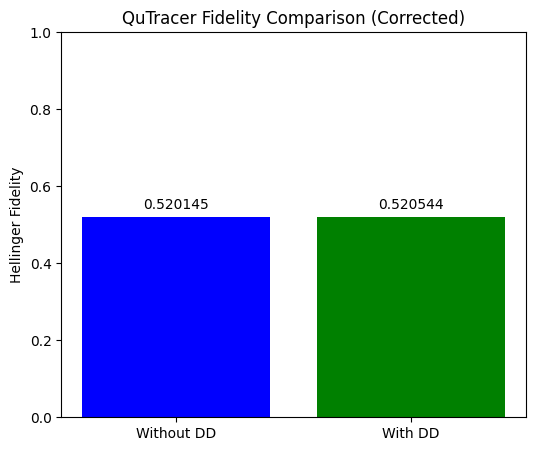

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import json


def hellinger_fidelity(dist_p, dist_q):
    p_sum = sum(dist_p.values())
    q_sum = sum(dist_q.values())
    keys = set(dist_p.keys()) | set(dist_q.keys())
    total = sum((np.sqrt(dist_p.get(k, 0)/p_sum) - np.sqrt(dist_q.get(k, 0)/q_sum))**2 for k in keys)
    return 1 - np.sqrt(total)/np.sqrt(2)


with open('ideal_counts.json', 'r') as f:
    ideal_counts = json.load(f)

with open('quTracer_counts_no_dd.json', 'r') as f:
    fragment_counts_no_dd = json.load(f)

with open('quTracer_counts_dd.json', 'r') as f:
    fragment_counts_dd = json.load(f)
    
if isinstance(fragment_counts_no_dd, list) and len(fragment_counts_no_dd) > 0:
    fragment_no_dd = norm_counts(fragment_counts_no_dd[0])
else:
    raise ValueError("fragment_counts_no_dd is empty or not a list")

if isinstance(fragment_counts_dd, list) and len(fragment_counts_dd) > 0:
    fragment_dd = norm_counts(fragment_counts_dd[0])
else:
    raise ValueError("fragment_counts_dd is empty or not a list")

normalized_no_dd = [(fragment_no_dd, 1, 0)]
reconstructed_global_no_dd = bayesian_reconstruct(norm_counts(ideal_counts), normalized_no_dd, cutting_bits=1)

normalized_dd = [(fragment_dd, 1, 0)]
reconstructed_global_dd = bayesian_reconstruct(norm_counts(ideal_counts), normalized_dd, cutting_bits=1)
fidelity_no_dd = hellinger_fidelity(norm_counts(ideal_counts), reconstructed_global_no_dd)
fidelity_dd = hellinger_fidelity(norm_counts(ideal_counts), reconstructed_global_dd)


print(f"QuTracer Fidelity WITHOUT DD: {fidelity_no_dd:.7f}")
print(f"QuTracer Fidelity WITH DD: {fidelity_dd:.7f}")
print(f"Fidelity Improvement: {(fidelity_dd - fidelity_no_dd)/fidelity_no_dd:.2%}")
labels = ['Without DD', 'With DD']
fidelities = [fidelity_no_dd, fidelity_dd]
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, fidelities, color=['blue', 'green'])
plt.ylabel('Hellinger Fidelity')
plt.ylim(0, 1)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{bar.get_height():.6f}', ha='center')

plt.title('QuTracer Fidelity Comparison (Corrected)')
plt.show()


In [18]:
##Graphs

C:\Users\Adrian\AppData\Local\Programs\Python\Python39\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


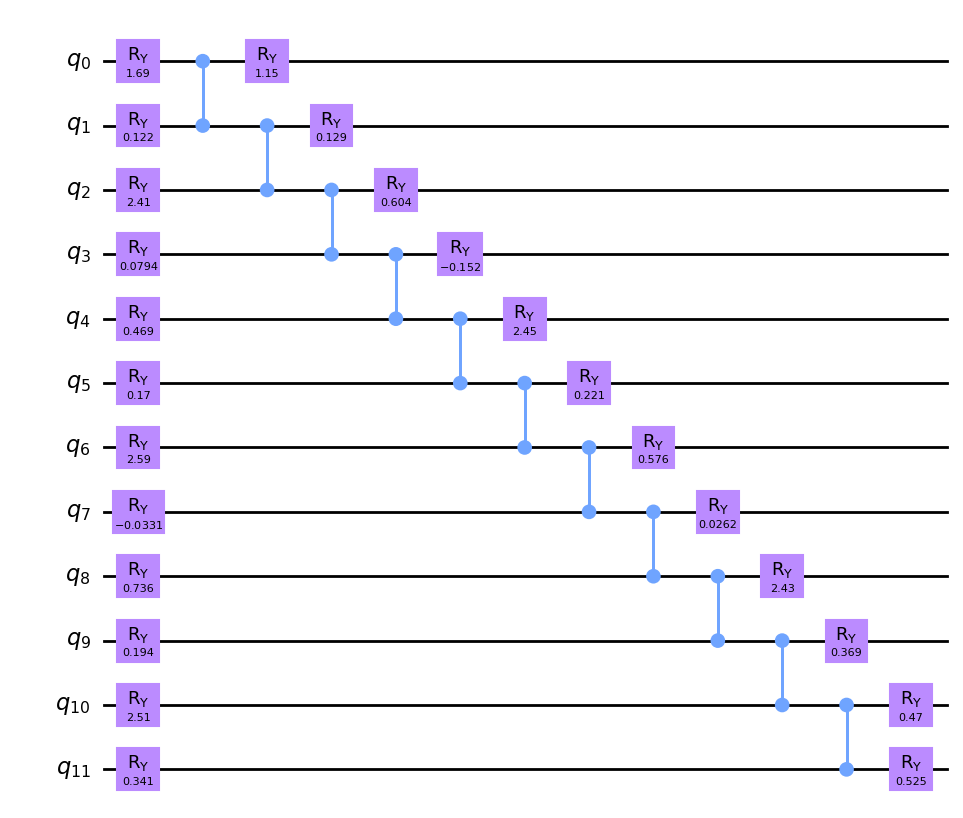

In [19]:
qc_no_dd.draw(output="mpl")

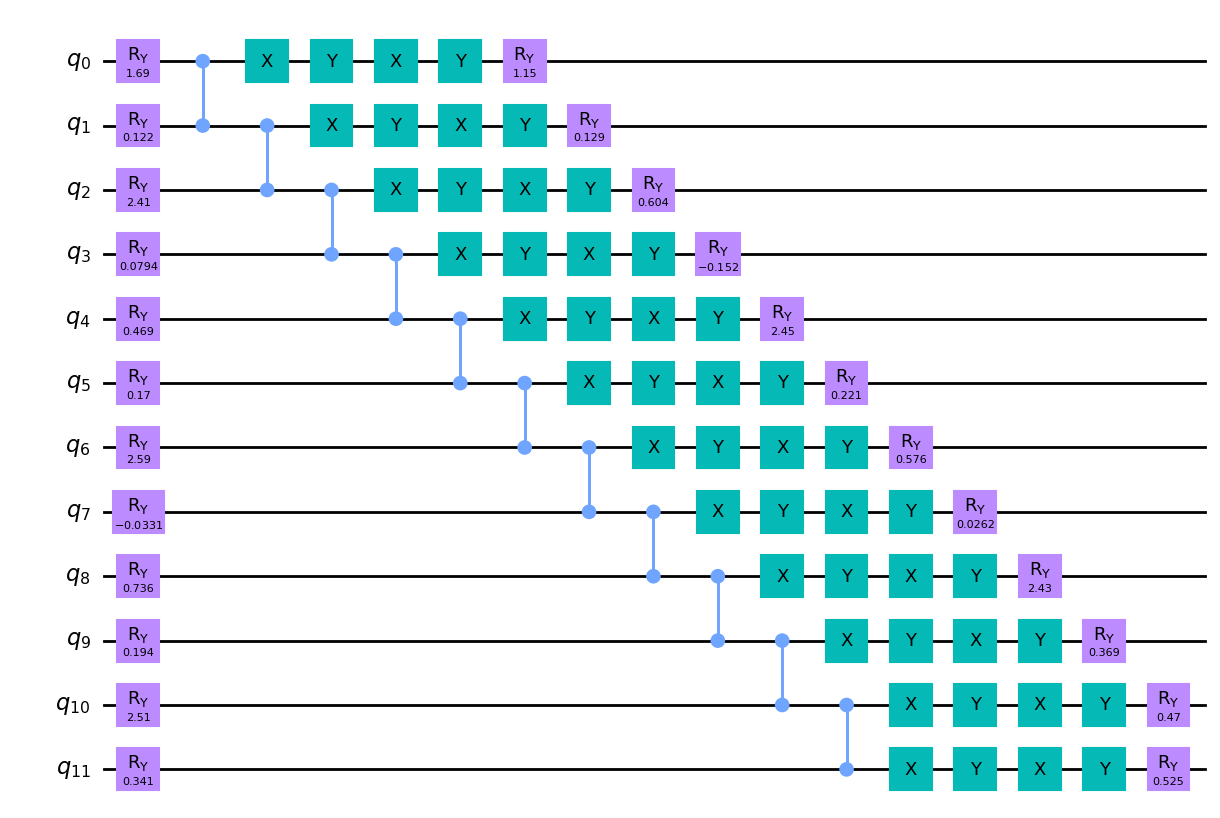

In [20]:
qc_dd.draw('mpl', fold=-1)